# Experiments on SisFall dataset processing

In [1]:
!ls

Bancario                             Heuristic Algorithms
ExperimentScipyNLP.ipynb             Impresa
Federated learning                   Massimo_Frasson_-_Game_Developer.pdf
FederatedLearningOutlierDetection    SisFallExperiments.ipynb
Funkestain                           pianoDiStudio.pdf
GPUcomputing                         soweegoazurevps_key.pem


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 5]

In [3]:
import pandas
import numpy as np

dataset_path = './FederatedLearningOutlierDetection/cache/SisFall_dataset/SisFall_dataset/SA01/F04_SA01_R01.txt'

In [4]:
with open(dataset_path) as f:
    for l in f:
        print(l)
        break

   0,-198, -55,-166,-181,-444, -77,-758, -49;



Like in the SisFall paper, we keep only the data from **ADXL345**.
Meaning we will keep only the first three columns from each csv file.

In [5]:
df = pandas.read_csv(dataset_path, header=None).iloc[:,:3]

In [6]:
df

,0,1,2
0,0,-198,-55
1,-7,-203,-50
2,-8,-211,-44
3,-10,-219,-47
4,-7,-226,-40
...,...,...,...
2995,-247,1,-49
2996,-245,-2,-50
2997,-245,2,-52
2998,-248,2,-50


## How do you do a sliding window?

The data were collected ad a 200Hz frequency.
This means that 200 rows are collected in a second.

So how much time did the experiment take? Does the number make sense?

In the cell below we do the computation and we find out the same number reported on page 4 of the paper

In [7]:
print(f'{len(df) / 200:.2f}s {len(df) / 200 / 60:.2f}min')

15.00s 0.25min


In [8]:
def window(k: int, Nv:int):
    # Avoids shorter windows at the end 
    # which would give much more importance to the lateset samples
    # I use iloc[0:0] to return the columns expected
    begin = k - Nv + 1
    if begin < 0:
        return df.iloc[0:0]
    return df.iloc[begin:k+1]
    
window(k=6, Nv=5)

,0,1,2
2,-8,-211,-44
3,-10,-219,-47
4,-7,-226,-40
5,-7,-232,-28
6,-8,-235,-37


## How to compute the features from SisFall Paper?

## C1 - Sum vector magnitude

C1 feature is presented with the following equation: $C1[k] = RMS(ã[k]) = \sqrt{a_x^2[k] + a_y^2[k] + a_y^2[z]}$

**R**oot **M**ean **S**quare according to wikipedia is:

Given $n$ items $\{ x_1, ..., x_n \}$
$RMS = \sqrt {\frac{1}{n} (x_1^2 + ... + x_n^2)}$

A single measurement is instead defined as $\vec{a} = [a_x, a_y, a_z]^T$

So the formula $\sqrt{a_x^2[k] + a_y^2[k] + a_y^2[z]}$ would return a single real for each measurement k.

Instead $RMS(ã[k]) = \sqrt{ \frac{1}{|ã[k]|} (\vec{a}^T[k - Nv + 1]^2 + ... + \vec{a}^T[k]^2})$, which results in a vector.

In my opinion the equation makes no sense, so let's follow the train of logic.

In the literature by *Sum vector magnitude* of a vector $\vec{a} = \sqrt{a_x^2[k] + a_y^2[k] + a_y^2[z]}$.

Also, from the literature, a feature is usually a single real value.

So it makes sense to compute sum vector magnitude for each sample, and then RMS them and provide the real result as C1.

In [9]:
def c1(x, y, z):
    for i in range(len(x)):
        measure = np.array([x[i], y[i], z[i]])
        yield np.sqrt(np.sum(measure ** 2))
    
df['c1'] = list(c1(df.iloc[:,0], df.iloc[:,1], df.iloc[:,2]))

In [10]:
df

,0,1,2,c1
0,0,-198,-55,205.496959
1,-7,-203,-50,209.184129
2,-8,-211,-44,215.687274
3,-10,-219,-47,224.209723
4,-7,-226,-40,229.619250
...,...,...,...,...
2995,-247,1,-49,251.815409
2996,-245,-2,-50,250.057993
2997,-245,2,-52,250.465566
2998,-248,2,-50,252.998024


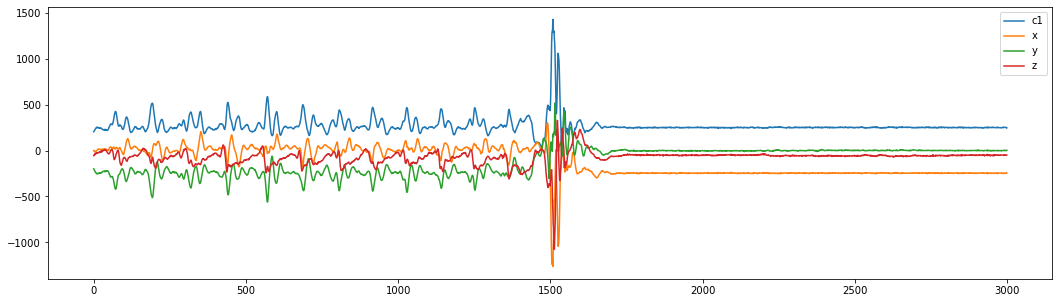

In [11]:
plt.plot(df['c1'], label='c1')
plt.plot(df.iloc[:, 0], label = 'x')
plt.plot(df.iloc[:, 1], label = 'y')
plt.plot(df.iloc[:, 2], label = 'z')
plt.legend()
plt.show()

Now that we got the **sum vector magnitude** for each sample, let's rms them by window

In [32]:
df['wc1'] = 0

Nv = 100 # 500ms window
k = Nv

w = window(k, Nv)
while k < len(df)-Nv:
    w_rms = np.sqrt(np.mean(np.array(w['c1']**2)))
    df.iloc[k, df.columns.get_loc("wc1")] = w_rms
    k += 1
    w = window(k, Nv)

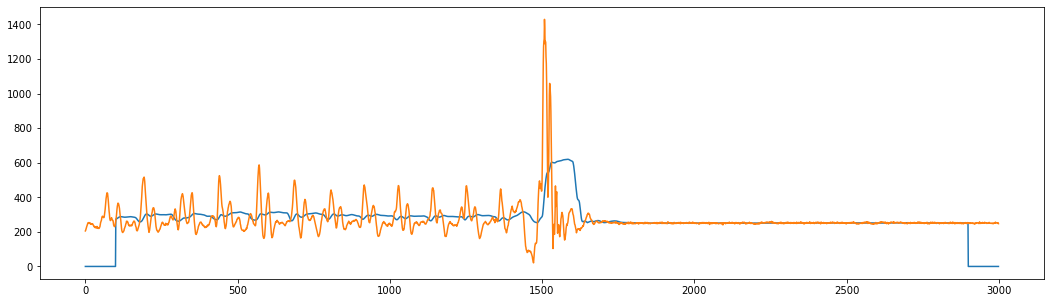

In [39]:
plt.plot(df['wc1'], label='wc1')
plt.plot(df['c1'], label='c1')
plt.show()

## C2 - Sum vector magnitude on horizontal plane

I am going to follow the same logic as above.

In [12]:
def c2(x, z):
    for i in range(len(x)):
        measure = np.array([x[i], z[i]])
        yield np.sqrt(np.sum(measure ** 2))
    
df['c2'] = list(c2(df.iloc[:,0], df.iloc[:,2]))

In [13]:
df

,0,1,2,c1,c2
0,0,-198,-55,205.496959,55.000000
1,-7,-203,-50,209.184129,50.487622
2,-8,-211,-44,215.687274,44.721360
3,-10,-219,-47,224.209723,48.052055
4,-7,-226,-40,229.619250,40.607881
...,...,...,...,...,...
2995,-247,1,-49,251.815409,251.813423
2996,-245,-2,-50,250.057993,250.049995
2997,-245,2,-52,250.465566,250.457581
2998,-248,2,-50,252.998024,252.990118


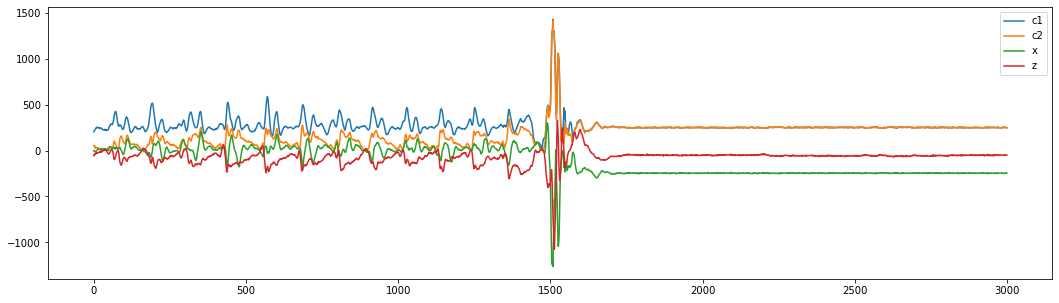

In [14]:
plt.plot(df['c1'], label='c1')
plt.plot(df['c2'], label='c2')
plt.plot(df.iloc[:, 0], label = 'x')
plt.plot(df.iloc[:, 2], label = 'z')
plt.legend()
plt.show()

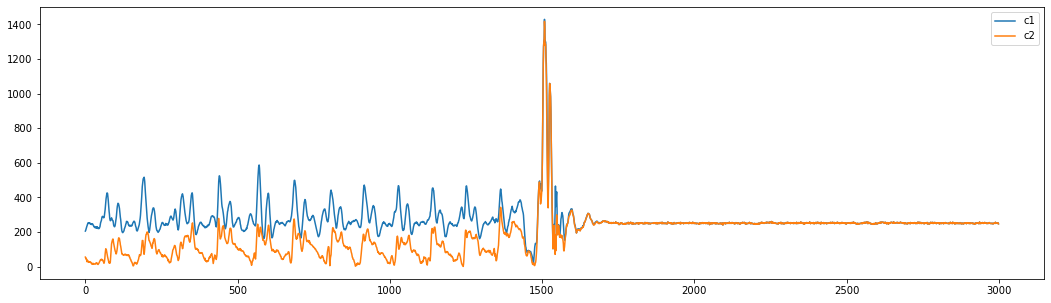

In [15]:
plt.plot(df['c1'], label='c1')
plt.plot(df['c2'], label='c2')
plt.legend()
plt.show()

In [40]:
df['wc2'] = 0

Nv = 100 # 500ms window
k = Nv

w = window(k, Nv)
while k < len(df)-Nv:
    w_rms = np.sqrt(np.mean(np.array(w['c2']**2)))
    df.iloc[k, df.columns.get_loc("wc2")] = w_rms
    k += 1
    w = window(k, Nv)

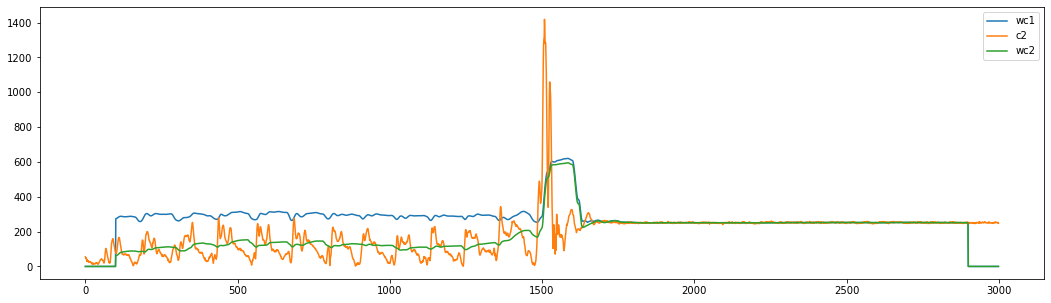

In [41]:
plt.plot(df['wc1'], label='wc1')
plt.plot(df['c2'], label='c2')
plt.plot(df['wc2'], label='wc2')
plt.legend()
plt.show()

## C3 - Maximum peak-to-peak acceleration amplitude

In the paper is defined as $C3[k] = RMS(max(ã[k]) - min(ã[k]))$

It's a mistery to me what does max/min mean on a list of vectors.

My best guess, as above, is to treat $max(ã[k])$ as the maximum C1 of one of the vectors in $[\vec{a}^T[k - Nv + 1], ..., \vec{a}^T[k]]$. The same for the min.

In [16]:
window(10, Nv=5)['c1'].argmax()

3

In [17]:
window(10, Nv=5)

,0,1,2,c1,c2
6,-8,-235,-37,238.029410,37.854986
7,-8,-243,-29,244.855059,30.083218
8,-4,-245,-29,246.742781,29.274562
9,-1,-251,-32,253.033595,32.015621
10,-2,-249,-26,250.361738,26.076810


In [18]:
window(10, Nv=5)['c1'].argmin()

0

In [19]:
f'C3 would be {window(10, Nv=5).iloc[4,3] - window(10, Nv=5).iloc[0,3]} for k = 10'

'C3 would be 12.332328343223423 for k = 10'

In [20]:
# This cell computes c3, it is not a function

df['c3'] = 0

Nv = 100 # 500ms window
k = Nv

w = window(k, Nv)
while k < len(df)-Nv:
    i_min = w['c1'].argmin()
    i_max = w['c1'].argmax()
    ptp = w.iloc[i_max, w.columns.get_loc("c1")] - w.iloc[i_min, w.columns.get_loc("c1")]
    df.iloc[k, df.columns.get_loc("c3")] = ptp
    k += 1
    w = window(k, Nv)
    
df = df.dropna()

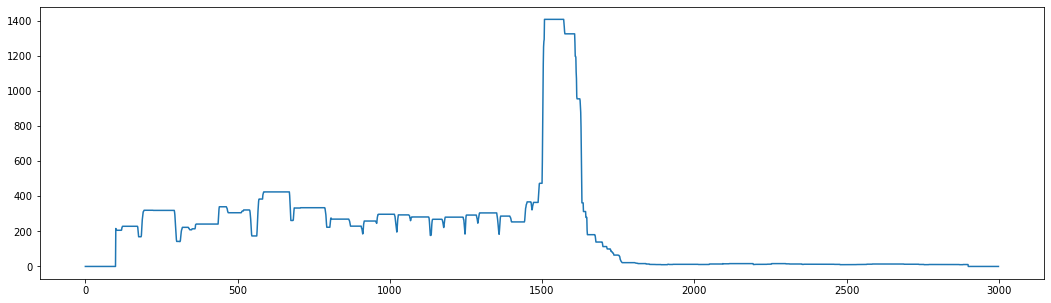

In [21]:
plt.plot(df['c3'])
plt.show()

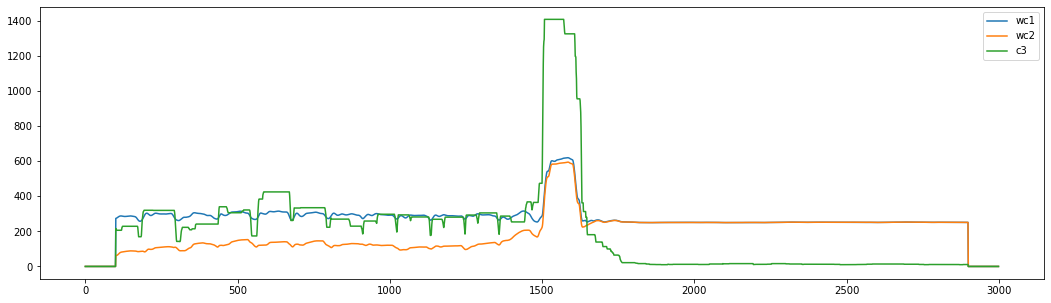

In [42]:
plt.plot(df['wc1'], label='wc1')
plt.plot(df['wc2'], label='wc2')
plt.plot(df['c3'], label='c3')
plt.legend()
plt.show()

## How do you filter data?

The filter used in the paper is a **4th order IIR Butterworth low-pass filter with cut-off frequency of 5 Hz**

In [23]:
from scipy.signal import butter, filtfilt

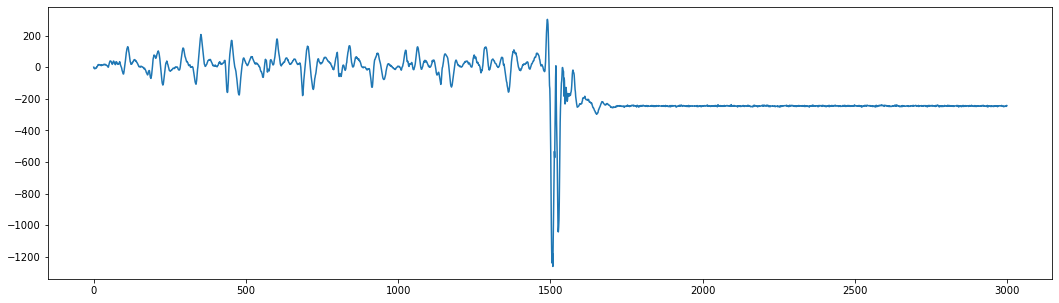

In [24]:
plt.plot(df.iloc[:,0])

plt.show()

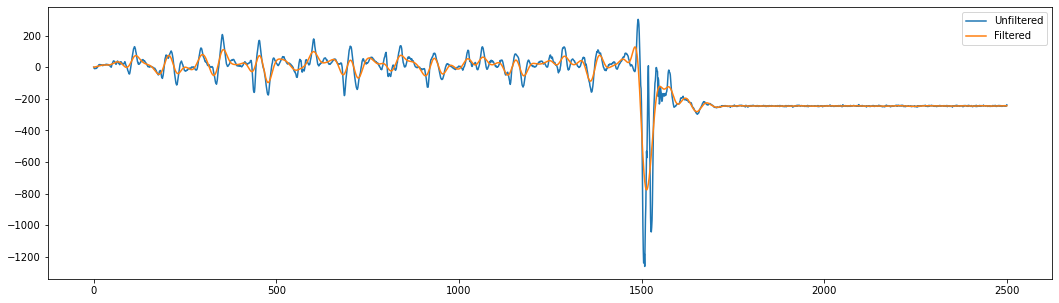

In [44]:
def filter_column(col):
    order = 4
    cutoff = 5
    fs = 200
    nyq = 0.5 * fs

    normal_cutoff = cutoff / nyq

    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, col)

filtered = filter_column(df.iloc[:,0])

plt.plot(df.iloc[:2500, 0], label='Unfiltered')
plt.plot(filtered[:2500], label='Filtered')
plt.legend()
plt.show()

In [26]:
df['f0'] = filter_column(df.iloc[:,0])
df['f1'] = filter_column(df.iloc[:,1])
df['f2'] = filter_column(df.iloc[:,2])

In [27]:
df

,0,1,2,c1,c2,c3,f0,f1,f2
0,0,-198,-55,205.496959,55.000000,0.0,-0.026177,-198.305167,-56.611438
1,-7,-203,-50,209.184129,50.487622,0.0,0.405463,-203.257107,-53.918954
2,-8,-211,-44,215.687274,44.721360,0.0,0.848935,-208.178509,-51.201655
3,-10,-219,-47,224.209723,48.052055,0.0,1.310007,-213.021705,-48.474533
4,-7,-226,-40,229.619250,40.607881,0.0,1.793658,-217.739716,-45.751984
...,...,...,...,...,...,...,...,...,...
2995,-247,1,-49,251.815409,251.813423,0.0,-245.101118,1.798074,-48.997727
2996,-245,-2,-50,250.057993,250.049995,0.0,-245.020331,1.902604,-48.962985
2997,-245,2,-52,250.465566,250.457581,0.0,-244.941418,1.997720,-48.928471
2998,-248,2,-50,252.998024,252.990118,0.0,-244.865992,2.082899,-48.895043
